In [85]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf 
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from statsmodels.tools.tools import add_constant
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf 
import random as rm
import time as tm
import matplotlib.pyplot as plt
from scipy import stats
from pandas.api.types import is_string_dtype 
from pandas.api.types import is_numeric_dtype 
import sklearn.metrics as skm
import sklearn.impute as ski
from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import pacf
import scipy.stats as stats
import statistics
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
import itertools

In [86]:
df1 = pd.read_csv('multivariate_eng_df.csv')
df1.drop(columns=['Unnamed: 0', 'STATE'], inplace=True)
df1['PEOPLE_POSITIVE_NEW_CASES_COUNT'] = df1['PEOPLE_POSITIVE_NEW_CASES_COUNT'].astype(int)
df1.set_index('Date',inplace=True)
df1.sort_index(inplace=True)
df1 = df1[['PEOPLE_POSITIVE_NEW_CASES_COUNT','PROVINCE_STATE_NAME']]
df1

,PEOPLE_POSITIVE_NEW_CASES_COUNT,PROVINCE_STATE_NAME
Date,,
2020-03-01,5,California
2020-03-01,0,Michigan
2020-03-01,0,Georgia
2020-03-01,0,New York
2020-03-01,0,North Carolina
...,...,...
2022-04-29,0,Georgia
2022-04-29,0,Florida
2022-04-29,18896,California


In [87]:
# Define the list of states
states = ['California', 'Texas', 'Florida', 'New York', 'Pennsylvania', 'Illinois', 'Ohio', 'Georgia', 'North Carolina', 'Michigan']

# Dictionary to hold DataFrames for each state
state_data = {}

# Dictionary to hold training and test data for each state
state_training_data = {}
state_test_data = {}

# Loop through each state
for state in states:
    # Filter the DataFrame for the current state
    df_state = df1.loc[df1['PROVINCE_STATE_NAME'] == state].copy()  # Make a copy to avoid SettingWithCopyWarning
    
    # Drop the 'PROVINCE_STATE_NAME' column from the filtered DataFrame
    df_state.drop(columns=['PROVINCE_STATE_NAME'], inplace=True)
    
    # Sort the DataFrame by index
    df_state.sort_index(inplace=True)
    
    # Split the data into training and test sets
    train_data = df_state.iloc[:632]  # First 6320 rows for training
    test_data = df_state.iloc[632:]   # Remaining rows for test
    
    # Save the modified DataFrame to the dictionary
    state_data[state] = df_state
    
    # Save the training and test data to respective dictionaries
    state_training_data[state] = train_data
    state_test_data[state] = test_data

In [88]:
CA_train = state_training_data['California']
CA_train

,PEOPLE_POSITIVE_NEW_CASES_COUNT
Date,
2020-03-01,5
2020-03-02,5
2020-03-03,7
2020-03-04,10
2020-03-05,12
...,...
2021-11-18,6627
2021-11-19,6090
2021-11-20,1853


In [89]:
CA_test = state_test_data['California']
CA_test.rename(columns={'PEOPLE_POSITIVE_NEW_CASES_COUNT': 'PEOPLE_POSITIVE_NEW_CASES_COUNT_p'}, inplace=True)
CA_test

,PEOPLE_POSITIVE_NEW_CASES_COUNT_p
Date,
2021-11-23,4541
2021-11-24,4168
2021-11-25,2
2021-11-26,1990
2021-11-27,618
...,...
2022-04-25,4531
2022-04-26,16180
2022-04-27,1852


In [90]:
CA_test \
    .rename(columns={'CA_test': 'TEST SET'}) \
    .join(CA_train.rename(columns={'CA_train': 'TRAINING SET'}), how='outer')

,PEOPLE_POSITIVE_NEW_CASES_COUNT_p,PEOPLE_POSITIVE_NEW_CASES_COUNT
Date,,
2020-03-01,NaN,5.0
2020-03-02,NaN,5.0
2020-03-03,NaN,7.0
2020-03-04,NaN,10.0
2020-03-05,NaN,12.0
...,...,...
2022-04-25,4531.0,NaN
2022-04-26,16180.0,NaN
2022-04-27,1852.0,NaN


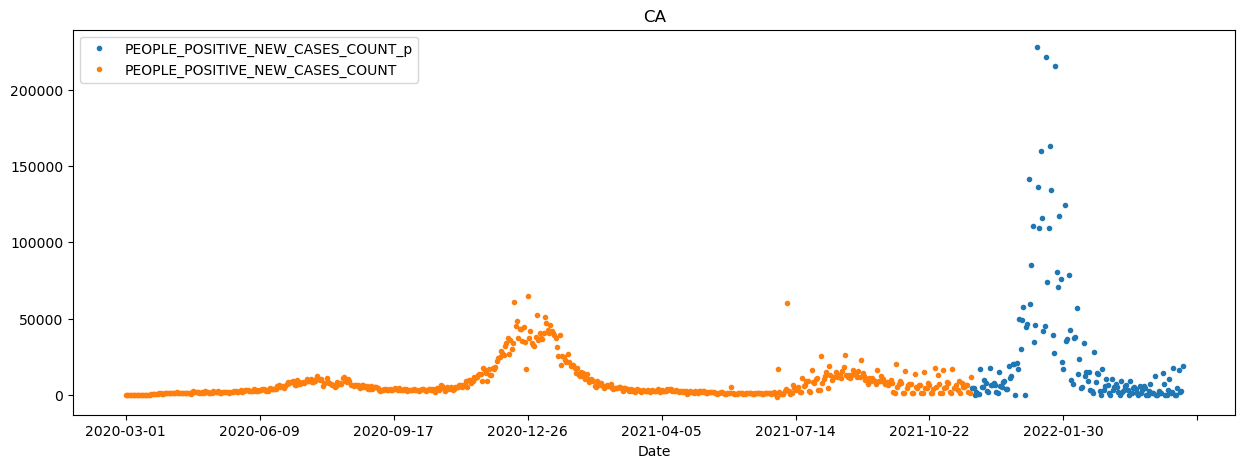

In [91]:
_ = CA_test \
    .rename(columns={'CA_test': 'TEST SET'}) \
    .join(CA_train.rename(columns={'CA_train': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(15,5), title='CA', style='.')


In [96]:
grid_search_results = {}

# Loop through each state's data frame
for state_abbr, state_df in state_data.items():
    print(f"Running grid search for {state_abbr}...")
    
    # Initialize list to store results for the current state
    state_results = []
    
    # Loop through different values of p and q
    for p in range(1, 10):
        for q in range(1, 10):
            try:
                # Fit ARIMA model
                model = ARIMA(state_df['PEOPLE_POSITIVE_NEW_CASES_COUNT'], order=(p, 1, q)).fit()
                
                # Store results: p, q, AIC
                state_results.append([p, q, model.aic, model.bic])
            except:
                pass  # Skip if model fitting fails
    
    # Store results for the current state in the dictionary
    grid_search_results[state_abbr] = state_results

# Displaying the results for each state
for state_abbr, results in grid_search_results.items():
    print(f"Grid search results for {state_abbr}:")
    df_results_uni = pd.DataFrame(results, columns=['p', 'q', 'AIC', 'BIC']).sort_values(by='AIC')
    print(df_results_uni)

Running grid search for California...
Running grid search for Texas...
Running grid search for Florida...
Running grid search for New York...
Running grid search for Pennsylvania...
Running grid search for Illinois...
Running grid search for Ohio...
Running grid search for Georgia...
Running grid search for North Carolina...
Running grid search for Michigan...
Grid search results for California:
    p  q           AIC           BIC
80  9  9  16710.370668  16799.115228
62  7  9  16710.791944  16790.194972
71  8  9  16712.237919  16796.311712
79  9  8  16735.564569  16819.638363
53  6  9  16738.478797  16813.211058
.. .. ..           ...           ...
2   1  3  17241.703428  17265.057259
56  7  3  17250.629750  17302.008180
28  4  2  17275.503340  17308.198704
1   1  2  17298.972874  17317.655939
0   1  1  17327.908655  17341.920953

[81 rows x 4 columns]
Grid search results for Texas:
    p  q           AIC           BIC
70  8  8  16205.780867  16285.183895
79  9  8  16207.643731  16291

In [98]:
for state_abbr, results in grid_search_results.items():
    print(f"First value in {state_abbr} results:")
    df_results_uni = pd.DataFrame(results, columns=['p', 'q', 'AIC', 'BIC']).sort_values(by='AIC')
    print(df_results_uni.head(1))

First value in California results:
    p  q           AIC           BIC
80  9  9  16710.370668  16799.115228
First value in Texas results:
    p  q           AIC           BIC
70  8  8  16205.780867  16285.183895
First value in Florida results:
    p  q           AIC           BIC
71  8  9  16835.521748  16919.595541
First value in New York results:
    p  q           AIC          BIC
79  9  8  13764.546026  13848.61982
First value in Pennsylvania results:
    p  q           AIC           BIC
80  9  9  13675.759659  13764.504219
First value in Illinois results:
    p  q           AIC           BIC
80  9  9  15647.360952  15736.105512
First value in Ohio results:
    p  q           AIC          BIC
35  4  9  14469.280711  14534.67144
First value in Georgia results:
    p  q           AIC           BIC
80  9  9  15374.728745  15463.473305
First value in North Carolina results:
    p  q           AIC           BIC
80  9  9  15727.237248  15815.981808
First value in Michigan results:
    p

In [100]:
CA = state_data['California']
TX = state_data['Texas']
FL = state_data['Florida']
NY = state_data['New York']
PA = state_data['Pennsylvania']
IL = state_data['Illinois']
OH = state_data['Ohio']
GA = state_data['Georgia']
NC = state_data['North Carolina']
MI = state_data['Michigan']

In [102]:
CA_ARIMA = ARIMA(CA['PEOPLE_POSITIVE_NEW_CASES_COUNT'], order=(4, 1, 4)).fit()
TX_ARIMA = ARIMA(TX['PEOPLE_POSITIVE_NEW_CASES_COUNT'], order=(4, 1, 4)).fit()
FL_ARIMA = ARIMA(FL['PEOPLE_POSITIVE_NEW_CASES_COUNT'], order=(4, 1, 4)).fit()
NY_ARIMA = ARIMA(NY['PEOPLE_POSITIVE_NEW_CASES_COUNT'], order=(4, 1, 4)).fit()
PA_ARIMA = ARIMA(PA['PEOPLE_POSITIVE_NEW_CASES_COUNT'], order=(3, 1, 4)).fit()
IL_ARIMA = ARIMA(IL['PEOPLE_POSITIVE_NEW_CASES_COUNT'], order=(4, 1, 4)).fit()
OH_ARIMA = ARIMA(OH['PEOPLE_POSITIVE_NEW_CASES_COUNT'], order=(3, 1, 4)).fit()
GA_ARIMA = ARIMA(GA['PEOPLE_POSITIVE_NEW_CASES_COUNT'], order=(4, 1, 4)).fit()
NC_ARIMA = ARIMA(NC['PEOPLE_POSITIVE_NEW_CASES_COUNT'], order=(4, 1, 4)).fit()
MI_ARIMA = ARIMA(MI['PEOPLE_POSITIVE_NEW_CASES_COUNT'], order=(4, 1, 4)).fit()

In [103]:
# Define function to calculate Mean Absolute Scaled Error (MASE)
def mean_absolute_scaled_error(y_true, y_pred, y_train):
    values = []
    for i in range(1, len(y_true)):
        values.append(abs(y_true[i] - y_pred[i]) / (abs(y_true[i] - y_true[i - 1]) / len(y_true) - 1))
    return np.mean(values)

# Initialize a dictionary to store evaluation metrics for each model
evaluation_metrics = {}

# Calculate evaluation metrics for each model
for state_abbr, model in [('CA', CA_ARIMA), ('TX', TX_ARIMA), ('FL', FL_ARIMA), ('NY', NY_ARIMA),
                          ('PA', PA_ARIMA), ('IL', IL_ARIMA), ('OH', OH_ARIMA), ('GA', GA_ARIMA),
                          ('NC', NC_ARIMA), ('MI', MI_ARIMA)]:
    # Get the target variable values
    state_df = eval(state_abbr)
    y_true = state_df['PEOPLE_POSITIVE_NEW_CASES_COUNT'].values
    
    # Make predictions
    y_pred = model.predict()
    
    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))

    # Calculate MASE
    mase = mean_absolute_scaled_error(y_true, y_pred, y_true)

    # Store evaluation metrics in the dictionary
    evaluation_metrics[state_abbr] = {'RMSE': rmse, 'MAPE': mape, 'MASE': mase}

# Display the evaluation metrics for each model
for state_abbr, metrics in evaluation_metrics.items():
    print(f"Evaluation metrics for {state_abbr}:")
    print(f"RMSE: {metrics['RMSE']:.2f}")
    print(f"MASE: {metrics['MASE']:.2f}")
    print()

Evaluation metrics for CA:
RMSE: 11600.17
MASE: -3356.10

Evaluation metrics for TX:
RMSE: 7108.58
MASE: -3400.65

Evaluation metrics for FL:
RMSE: 19960.35
MASE: -3552.69

Evaluation metrics for NY:
RMSE: 1511.86
MASE: -725.94

Evaluation metrics for PA:
RMSE: 1404.52
MASE: inf

Evaluation metrics for IL:
RMSE: 5198.84
MASE: 549.62

Evaluation metrics for OH:
RMSE: 2398.17
MASE: 91.34

Evaluation metrics for GA:
RMSE: 4229.76
MASE: -1169.99

Evaluation metrics for NC:
RMSE: 5340.23
MASE: -1476.73

Evaluation metrics for MI:
RMSE: 4288.93
MASE: -224.09



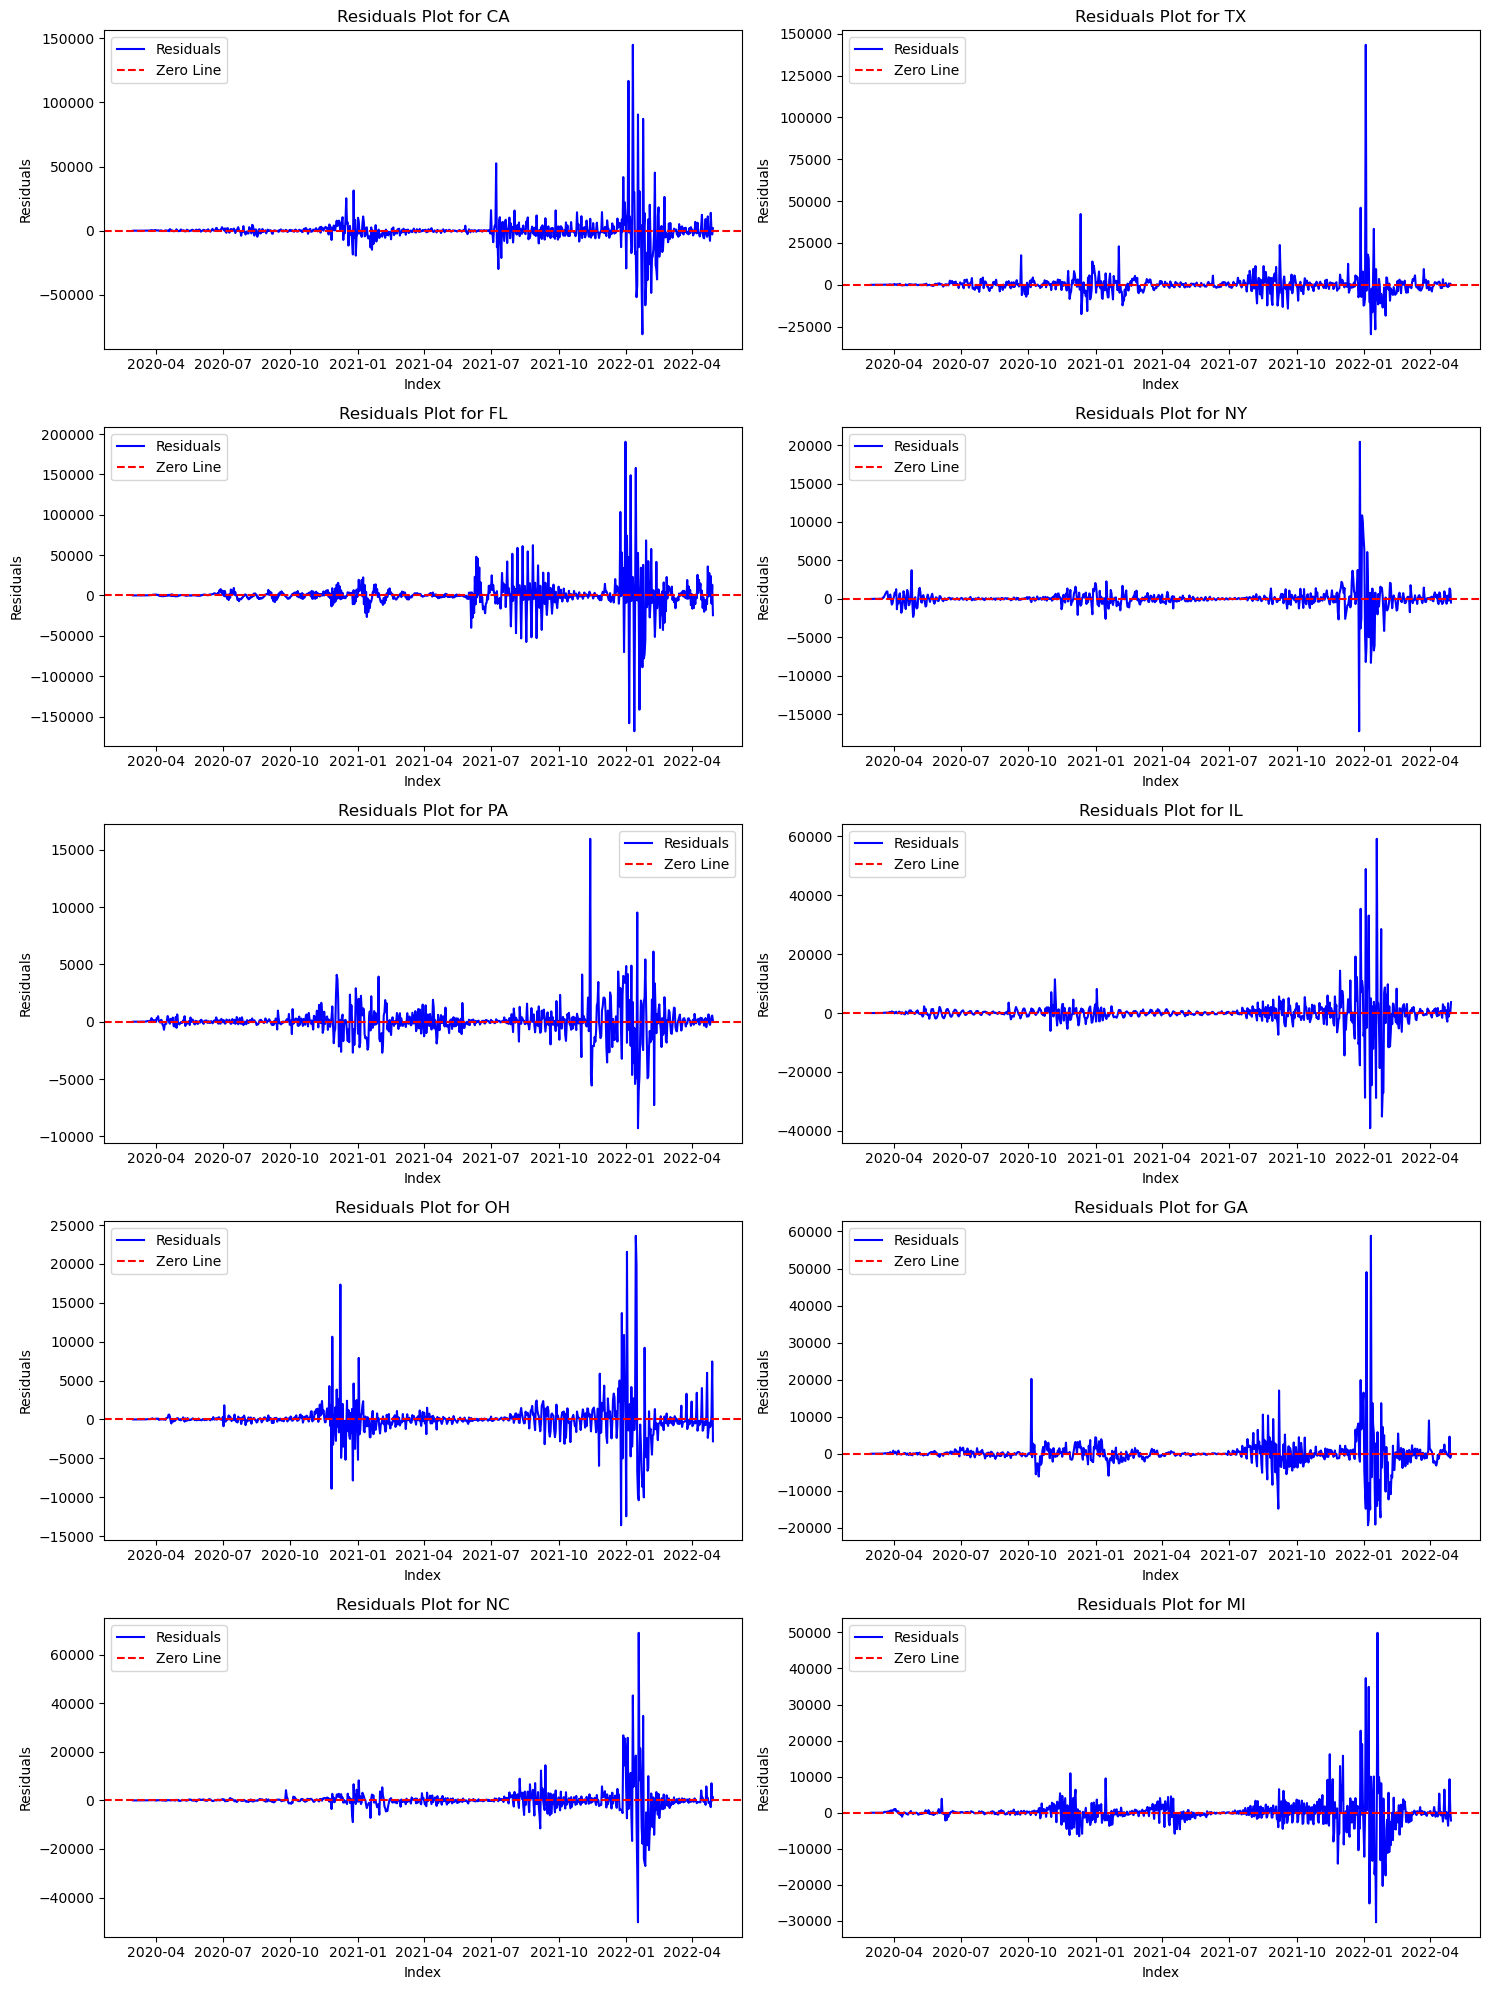

In [104]:
# Initialize a figure
fig, axs = plt.subplots(5, 2, figsize=(15, 20))

# Flatten the axis array for easier iteration
axs = axs.flatten()

# Plot residuals for each model
for i, (state_abbr, model) in enumerate([('CA', CA_ARIMA), ('TX', TX_ARIMA), ('FL', FL_ARIMA), ('NY', NY_ARIMA),
                                         ('PA', PA_ARIMA), ('IL', IL_ARIMA), ('OH', OH_ARIMA), ('GA', GA_ARIMA),
                                         ('NC', NC_ARIMA), ('MI', MI_ARIMA)]):
    # Get the state dataframe
    state_df = eval(state_abbr)
    
    # Get the target variable values
    y_true = state_df['PEOPLE_POSITIVE_NEW_CASES_COUNT'].values
    
    # Make predictions
    y_pred = model.predict()
    
    # Calculate residuals
    residuals = y_true - y_pred
    
    # Plot residuals
    axs[i].plot(residuals, label='Residuals', color='blue')
    axs[i].axhline(y=0, color='r', linestyle='--', label='Zero Line')
    axs[i].set_title(f"Residuals Plot for {state_abbr}")
    axs[i].set_xlabel("Index")
    axs[i].set_ylabel("Residuals")
    axs[i].legend()

# Adjust layout
plt.tight_layout()
plt.show()

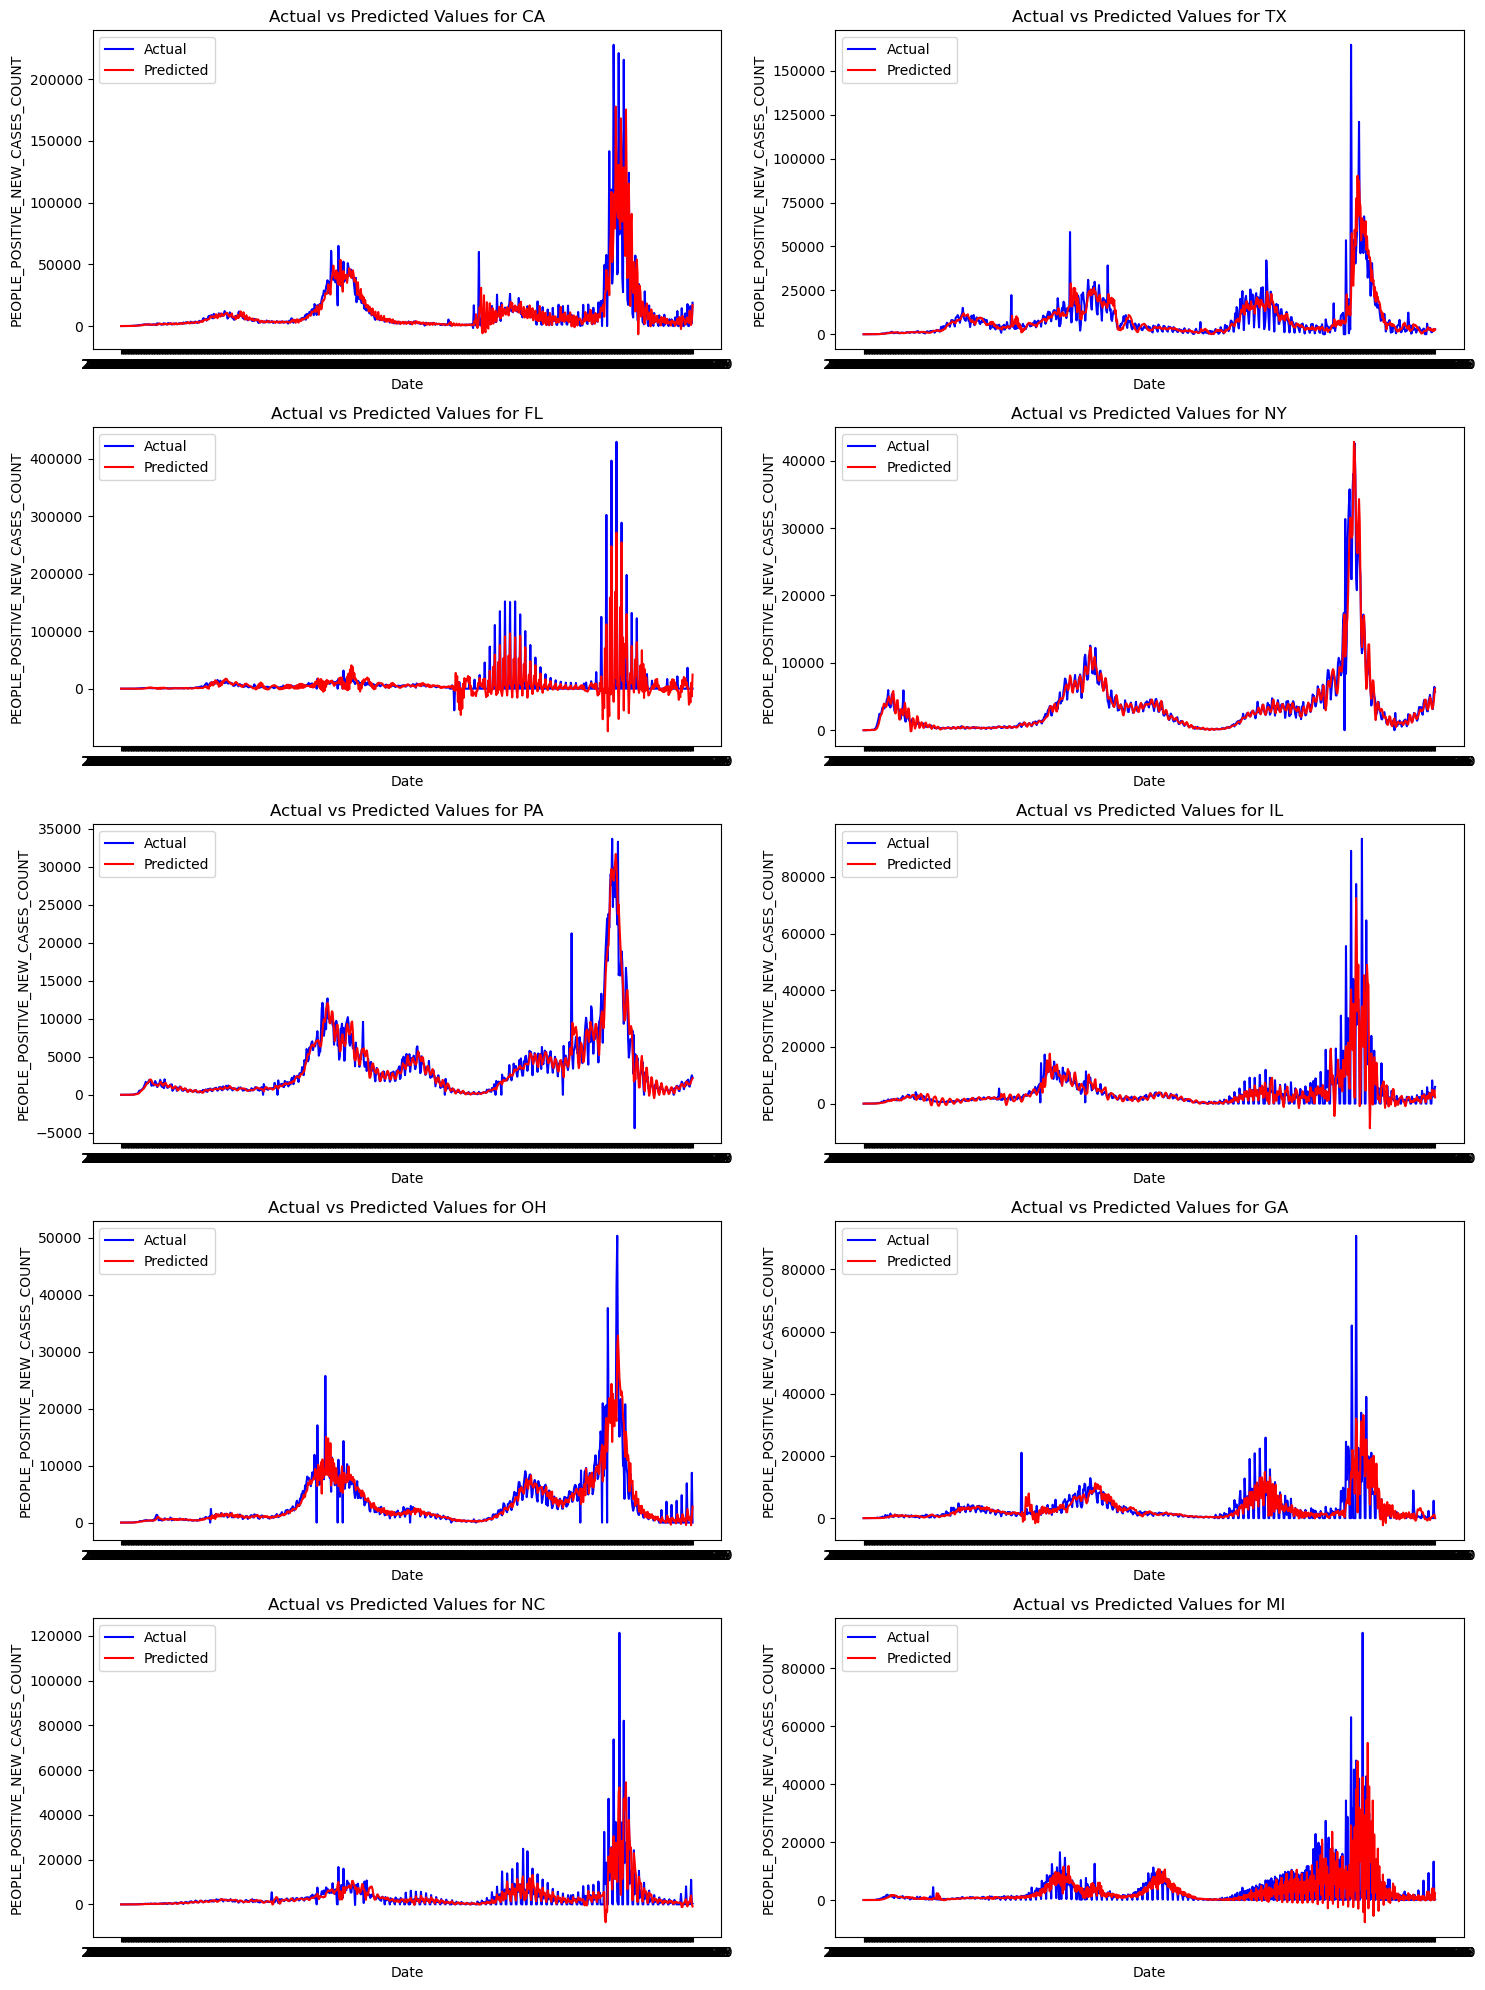

In [105]:
fig, axs = plt.subplots(5, 2, figsize=(15, 20))

# Flatten the axis array for easier iteration
axs = axs.flatten()

# Plot actual and predicted values for each model
for i, (state_abbr, model) in enumerate([('CA', CA_ARIMA), ('TX', TX_ARIMA), ('FL', FL_ARIMA), ('NY', NY_ARIMA),
                                         ('PA', PA_ARIMA), ('IL', IL_ARIMA), ('OH', OH_ARIMA), ('GA', GA_ARIMA),
                                         ('NC', NC_ARIMA), ('MI', MI_ARIMA)]):
    # Get the state dataframe
    state_df = eval(state_abbr)
    
    # Get the target variable values
    y_true = state_df['PEOPLE_POSITIVE_NEW_CASES_COUNT']
    
    # Make predictions
    y_pred = model.predict(dynamic=True)
    
    # Plot actual and predicted values
    axs[i].plot(state_df.index, y_true, label='Actual', color='blue')
    axs[i].plot(state_df.index, y_pred, label='Predicted', color='red')
    axs[i].set_title(f"Actual vs Predicted Values for {state_abbr}")
    axs[i].set_xlabel("Date")
    axs[i].set_ylabel("PEOPLE_POSITIVE_NEW_CASES_COUNT")
    axs[i].legend()

# Adjust layout
plt.tight_layout()
plt.show()

In [ ]:
grid_search_results = {}

# Loop through each state's data frame
for state_abbr, state_df in state_data.items():
    print(f"Running grid search for {state_abbr}...")
    
    # Get the list of exogenous variables (all variables except the target variable)
    exog_vars = [col for col in state_df.columns if col != 'PEOPLE_POSITIVE_NEW_CASES_COUNT']
    
    # Initialize list to store results for the current state
    state_results = []
    
    # Loop through different values of p and q
    for p in range(1, 5):
        for q in range(1, 5):
            try:
                # Fit ARIMA model with additional exogenous variables
                model = ARIMA(state_df['PEOPLE_POSITIVE_NEW_CASES_COUNT'], exog=state_df[exog_vars], order=(p, 1, q)).fit()
                
                # Store results: p, q, AIC
                state_results.append([p, q, model.aic, model.bic])
            except:
                pass  # Skip if model fitting fails
    
    # Store results for the current state in the dictionary
    grid_search_results[state_abbr] = state_results

# Displaying the results for each state
for state_abbr, results in grid_search_results.items():
    print(f"Grid search results for {state_abbr}:")
    df_results_multi = pd.DataFrame(results, columns=['p', 'q', 'AIC', 'BIC']).sort_values(by='AIC')
    print(df_results_multi)

Running grid search for California...


/Users/asherbank/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/asherbank/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/asherbank/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/asherbank/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/asherbank/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471

/Users/asherbank/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/asherbank/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/asherbank/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/asherbank/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/asherbank/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: N

In [36]:
CA = state_data['California']
CA.drop(columns=['PROVINCE_STATE_NAME'], inplace=True)

TX = state_data['Texas']
TX.drop(columns=['PROVINCE_STATE_NAME'], inplace=True)

FL = state_data['Florida']
FL.drop(columns=['PROVINCE_STATE_NAME'], inplace=True)

NY = state_data['New York']
NY.drop(columns=['PROVINCE_STATE_NAME'], inplace=True)

PA = state_data['Pennsylvania']
PA.drop(columns=['PROVINCE_STATE_NAME'], inplace=True)

IL = state_data['Illinois']
IL.drop(columns=['PROVINCE_STATE_NAME'], inplace=True)

OH = state_data['Ohio']
OH.drop(columns=['PROVINCE_STATE_NAME'], inplace=True)

GA = state_data['Georgia']
GA.drop(columns=['PROVINCE_STATE_NAME'], inplace=True)

NC = state_data['North Carolina']
NC.drop(columns=['PROVINCE_STATE_NAME'], inplace=True)

MI = state_data['Michigan']
MI.drop(columns=['PROVINCE_STATE_NAME'], inplace=True)

KeyError: "['PROVINCE_STATE_NAME'] not found in axis"

/Users/asherbank/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


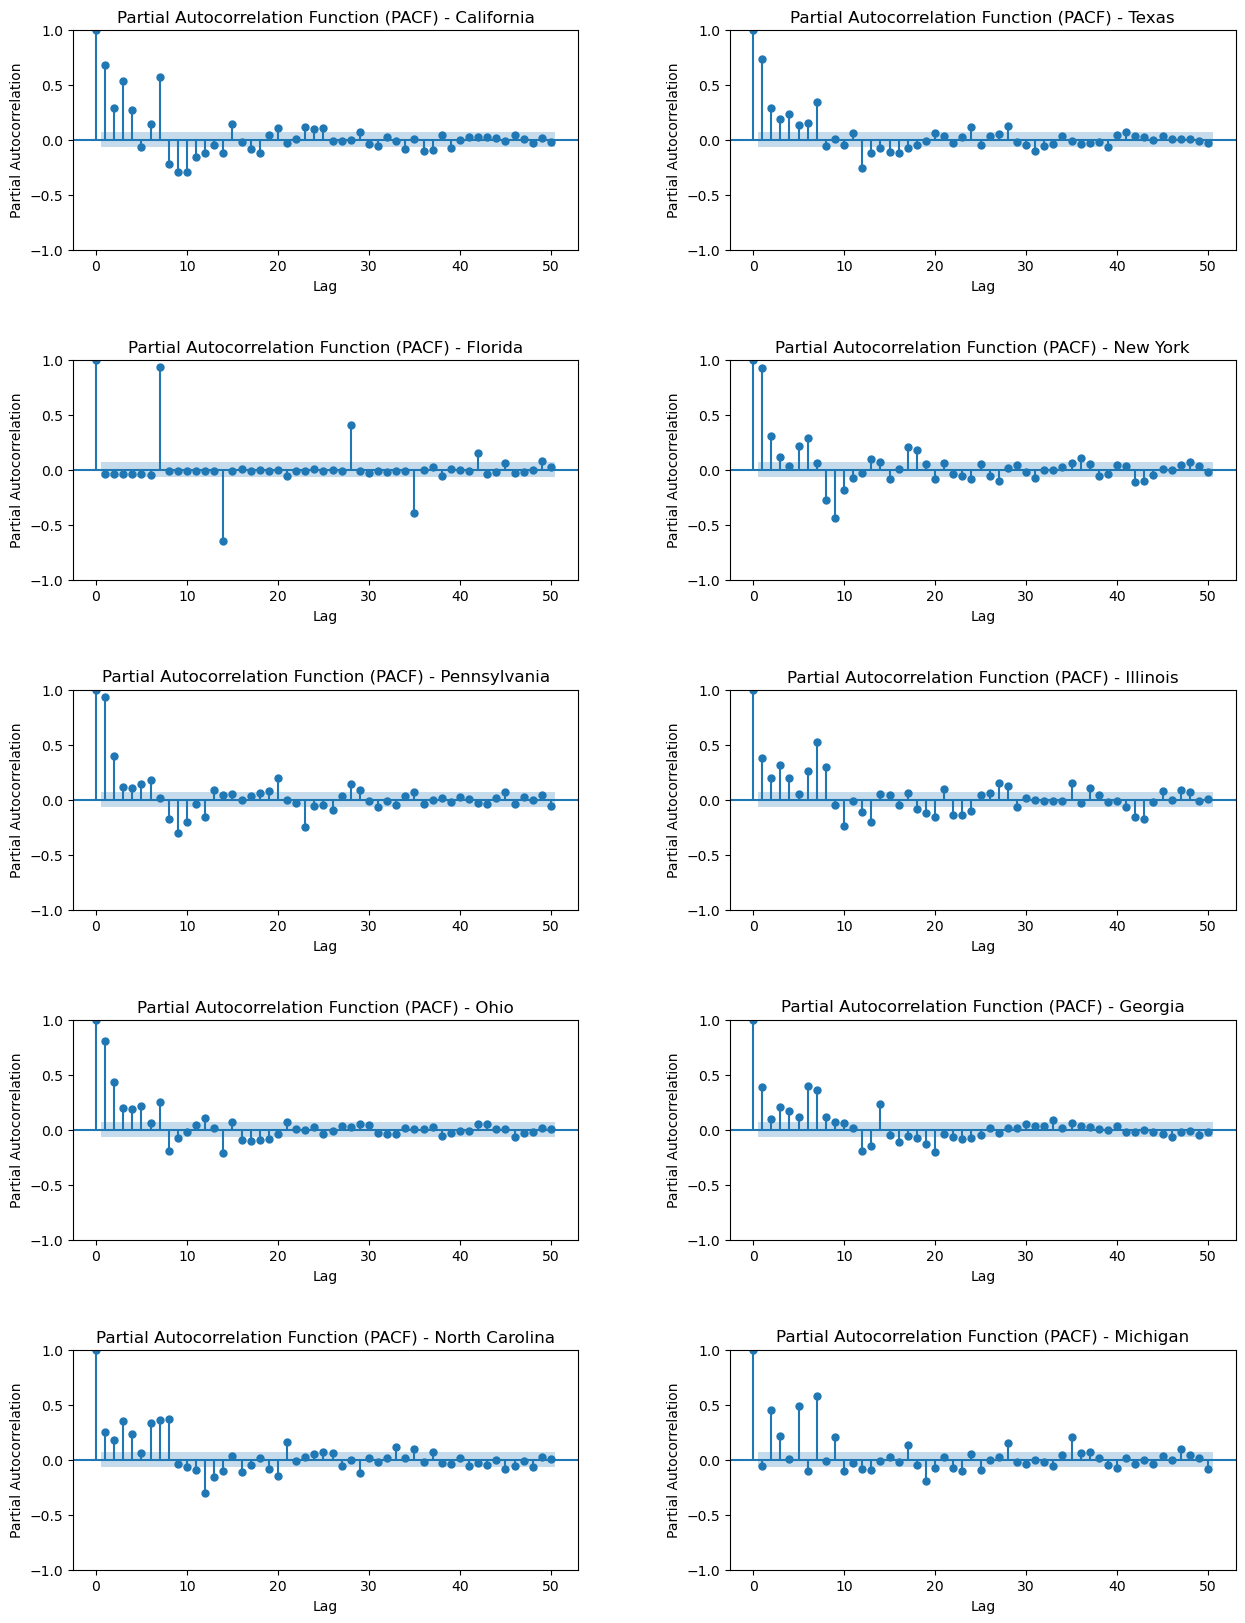

In [24]:
states = {'California': CA, 'Texas': TX, 'Florida': FL, 'New York': NY, 
          'Pennsylvania': PA, 'Illinois': IL, 'Ohio': OH, 'Georgia': GA, 
          'North Carolina': NC, 'Michigan': MI}

# Plot PACF for each state
fig, axs = plt.subplots(5, 2, figsize=(15, 20))
fig.subplots_adjust(hspace=0.5, wspace=0.3)

for i, (state_name, state_df) in enumerate(states.items()):
    ax = axs[i // 2, i % 2]
    plot_pacf(state_df['PEOPLE_POSITIVE_NEW_CASES_COUNT'], lags=50, ax=ax)
    ax.set_title(f'Partial Autocorrelation Function (PACF) - {state_name}')
    ax.set_xlabel('Lag')
    ax.set_ylabel('Partial Autocorrelation')

plt.show()

In [25]:
p_values = range(3)  # Adjust the range as needed
d_values = range(2)  # Adjust the range as needed
q_values = range(3)  # Adjust the range as needed

# Initialize variables to store best parameters and corresponding AIC
best_params = {}
best_aic = {}

# Iterate over each state's dataset
for state_name, state_df in states.items():
    # Initialize variables to store best AIC for the current state
    best_aic[state_name] = float('inf')
    
    # Iterate over all combinations of p, d, and q
    for p, d, q in itertools.product(p_values, d_values, q_values):
        try:
            # Fit ARIMA model
            model = ARIMA(state_df['PEOPLE_POSITIVE_NEW_CASES_COUNT'], order=(p, d, q))
            arima_result = model.fit()
            
            # Calculate AIC
            aic = arima_result.aic
            
            # Update best AIC and parameters if current model has lower AIC
            if aic < best_aic[state_name]:
                best_aic[state_name] = aic
                best_params[state_name] = {'p': p, 'd': d, 'q': q}
        except:
            pass  # Skip if model fitting fails

# Print best parameters for each state
for state_name, params in best_params.items():
    print(f"Best ARIMA parameters for {state_name}: p={params['p']}, d={params['d']}, q={params['q']}")

/Users/asherbank/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/asherbank/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/asherbank/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/asherbank/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, f

/Users/asherbank/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/asherbank/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/asherbank/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/asherbank/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/asherbank/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An u

/Users/asherbank/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/asherbank/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/asherbank/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/asherbank/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/asherbank/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An u

/Users/asherbank/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/asherbank/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/asherbank/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/asherbank/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/asherbank/opt/anaconda3/lib/python3.9/site-packages/statsmodels

/Users/asherbank/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/asherbank/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/asherbank/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/asherbank/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/asherbank/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An u

/Users/asherbank/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/asherbank/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/asherbank/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/asherbank/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/asherbank/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An u

/Users/asherbank/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/asherbank/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/asherbank/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/asherbank/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/asherbank/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An u

/Users/asherbank/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/asherbank/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/asherbank/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/asherbank/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/asherbank/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An u

/Users/asherbank/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/asherbank/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/asherbank/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/asherbank/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/asherbank/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An u

/Users/asherbank/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/asherbank/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/asherbank/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/asherbank/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/asherbank/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An u

/Users/asherbank/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/asherbank/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/asherbank/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/asherbank/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/asherbank/opt/anaconda3/lib/python3.9/site-packages/statsmodels

/Users/asherbank/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/asherbank/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/asherbank/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/asherbank/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/asherbank/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An u

/Users/asherbank/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/asherbank/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/asherbank/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/asherbank/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/asherbank/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An u

/Users/asherbank/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/asherbank/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/asherbank/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/asherbank/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/asherbank/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An u

Best ARIMA parameters for California: p=2, d=1, q=1
Best ARIMA parameters for Texas: p=2, d=1, q=2
Best ARIMA parameters for Florida: p=2, d=1, q=2
Best ARIMA parameters for New York: p=2, d=1, q=2
Best ARIMA parameters for Pennsylvania: p=0, d=1, q=1
Best ARIMA parameters for Illinois: p=2, d=1, q=2
Best ARIMA parameters for Ohio: p=0, d=1, q=1
Best ARIMA parameters for Georgia: p=2, d=1, q=2
Best ARIMA parameters for North Carolina: p=2, d=1, q=2
Best ARIMA parameters for Michigan: p=1, d=1, q=1


In [27]:
CA_ARIMA = ARIMA(CA['PEOPLE_POSITIVE_NEW_CASES_COUNT'], order=(2, 1, 1)).fit()
TX_ARIMA = ARIMA(TX['PEOPLE_POSITIVE_NEW_CASES_COUNT'], order=(2, 1, 2)).fit()
FL_ARIMA = ARIMA(FL['PEOPLE_POSITIVE_NEW_CASES_COUNT'], order=(2, 1, 2)).fit()
NY_ARIMA = ARIMA(NY['PEOPLE_POSITIVE_NEW_CASES_COUNT'], order=(2, 1, 2)).fit()
PA_ARIMA = ARIMA(PA['PEOPLE_POSITIVE_NEW_CASES_COUNT'], order=(0, 1, 1)).fit()
IL_ARIMA = ARIMA(IL['PEOPLE_POSITIVE_NEW_CASES_COUNT'], order=(2, 1, 2)).fit()
OH_ARIMA = ARIMA(OH['PEOPLE_POSITIVE_NEW_CASES_COUNT'], order=(0, 1, 1)).fit()
GA_ARIMA = ARIMA(GA['PEOPLE_POSITIVE_NEW_CASES_COUNT'], order=(2, 1, 2)).fit()
NC_ARIMA = ARIMA(NC['PEOPLE_POSITIVE_NEW_CASES_COUNT'], order=(2, 1, 2)).fit()
MI_ARIMA = ARIMA(MI['PEOPLE_POSITIVE_NEW_CASES_COUNT'], order=(1, 1, 1)).fit()

/Users/asherbank/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/asherbank/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/asherbank/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/asherbank/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/asherbank/opt/anaconda3/lib/python3.9/site-packages/statsmodels

In [29]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Define function to calculate Mean Absolute Scaled Error (MASE)
def mean_absolute_scaled_error(y_true, y_pred, y_train):
    return np.mean(np.abs(y_true - y_pred)) / np.mean(np.abs(y_train.diff().dropna()))

# Initialize lists to store metrics for each model
models = ['CA', 'TX', 'FL', 'NY', 'PA', 'IL', 'OH', 'GA', 'NC', 'MI']
AIC = []
BIC = []
MAE = []
MSE = []
RMSE = []
MAPE = []
MASE = []

# Calculate metrics for each model
for state in models:
    model = globals()[f'{state}_ARIMA']  # Get the ARIMA model object
    residuals = model.resid
    predictions = model.predict()

    aic = model.aic
    bic = model.bic
    mae = mean_absolute_error(state['PEOPLE_POSITIVE_NEW_CASES_COUNT'], predictions)
    mse = mean_squared_error(state['PEOPLE_POSITIVE_NEW_CASES_COUNT'], predictions)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(state['PEOPLE_POSITIVE_NEW_CASES_COUNT'], predictions)
    mase = mean_absolute_scaled_error(state['PEOPLE_POSITIVE_NEW_CASES_COUNT'], predictions, state['PEOPLE_POSITIVE_NEW_CASES_COUNT'])

    AIC.append(aic)
    BIC.append(bic)
    MAE.append(mae)
    MSE.append(mse)
    RMSE.append(rmse)
    MAPE.append(mape)
    MASE.append(mase)

# Create DataFrame with the metrics
metrics_df = pd.DataFrame({
    'State': models,
    'AIC': AIC,
    'BIC': BIC,
    'Mean Absolute Error': MAE,
    'Mean Squared Error': MSE,
    'Root Mean Squared Error': RMSE,
    'Mean Absolute Percent Error': MAPE,
    'Mean Absolute Scaled Error': MASE
})

TypeError: string indices must be integers

In [ ]:
metrics_df